# <font color="#114b98">Catégorisez automatiquement des questions</font>

## <font color="#114b98">Notebook de test de différents modèles</font>

**Stack Overflow** est un site célèbre de questions-réponses liées au développement informatique.

L'objectif de ce projet est de développer un système de **suggestion de tags** pour ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

**Livrable** : Un notebook de test de différents modèles.

## <font color="#114b98">Sommaire</font>
[1. Chargement du jeu de données](#section_1)

[2. Approche non supervisée afin de proposer des mots clés](#section_2)

[3. Approche supervisée avec TF-IDF](#section_3)

[4. Approche supervisée avec bag-of-words](#section_4)

[5. Approche supervisée avec Word Embedding : Word2Vec](#section_5)

[6. Approche supervisée avec Word Embedding : BERT](#section_6)

[7. Approche supervisée avec Sentence Embedding : USE](#section_7)

## <font color="#114b98" id="section_1">1. Chargement du jeu de données</font>

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import ast
import random
# import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline

In [120]:
from sklearn.model_selection import train_test_split

In [121]:
plt.rc('axes', titlesize=22) 
plt.rc('axes', labelsize=18) 
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

In [122]:
main_path = 'N:/5 - WORK/1 - Projets/Projet 5/'
files = os.listdir(main_path+'saved_ressources/')
files

['bows.mm',
 'bows.mm.index',
 'bows1.mm',
 'bows1.mm.index',
 'bows2.mm',
 'bows2.mm.index',
 'data_cleaned.csv']

In [123]:
data = pd.read_csv(main_path+'saved_ressources/'+'data_cleaned.csv', encoding='utf8')

In [124]:
data = data.applymap(lambda x: ast.literal_eval(x))

In [125]:
data.head()

,Tags,Texts
0,"[macos, emacs, scheme, interpreter, sicp]","[interpreter, emacs, interpreter, python, inte..."
1,"[c#, functional-programming, delegates, lambda...","[scope, bug, compiler, voidfunction, delegate,..."
2,"[mysql, database, arrays, postgresql, stored-p...","[pass, array, procedure, pass, array, procedur..."
3,"[ios, objective-c, iphone, cocoa-touch, uibutton]","[state, need, figure, button, state, documenta..."
4,"[database, nhibernate, exception-handling, con...","[check, application, column, name, constraint,..."


In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159599 entries, 0 to 159598
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Tags    159599 non-null  object
 1   Texts   159599 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


Le jeu de données est trop important pour les temps de calculs à ma disposition.

J'ai deux possibilités : 
- prendre un sample de 10000 observations aléatoirement
- prendre les 10000 observations pour lesquelles la similarité entre les deux colonnes est importante

In [127]:
# data_sample = data.sample(10000)
# data_sample.reset_index(inplace=True, drop=True)
# print(data_sample.shape)
# data_sample.head()

In [128]:
from typing import List

In [129]:
def jaccard_similarity(list1: List[str], list2: List[str]) -> float:
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    jaccard_similarity = len(intersection) / len(union)
    return jaccard_similarity

def get_highest_similarity_rows(data: pd.DataFrame, col1: str, col2: str, n: int):
    data["jaccard_similarity"] = data.apply(lambda x: jaccard_similarity(x[col1], x[col2]), axis=1)
    data = data.sort_values(by="jaccard_similarity", ascending=False)
    return data.head(n)


data_sample = get_highest_similarity_rows(data, "Tags", "Texts", 10000)
data_sample.drop(['jaccard_similarity'], axis=1, inplace=True)
data_sample.reset_index(inplace=True, drop=True)
print(data_sample.shape)
data_sample.head()

(10000, 3)


,Tags,Texts,jaccard_similarity
0,"[javascript, jquery, string, date, object]","[jquery, javascript, convert, date, string, da...",0.833333
1,"[canvas, point, bezier, curve, coordinate]","[coordinate, point, curve, canvas, point, canvas]",0.800000
2,"[listview, javafx, tableview, scrollbar, hide]","[hide, scrollbar, listview, javafx, hide, scro...",0.800000
3,"[apache, import, export, repository, jackrabbit]","[way, import, export, apache, jackrabbit, way,...",0.714286
4,"[javascript, location, window, href, window-ob...","[window, location, href, window, javascript, d...",0.666667


In [99]:
texts_list = data_sample["Texts"].to_list()
tags_list = data_sample["Tags"].to_list()

In [100]:
flat_texts = [" ".join(text) for text in texts_list]
flat_tags = [" ".join(tag) for tag in tags_list]

In [101]:
vocabulary_texts = list(set([word for item in texts_list for word in item]))
vocabulary_tags = list(set([word for item in tags_list for word in item]))

In [102]:
scores = pd.DataFrame()

## <font color="#114b98" id="section_2">2. Approche non supervisée afin de proposer des mots clés</font>

In [103]:
# pip install --upgrade numpy==1.24.1
# pip install gensim==4.3.0
# pip install pyLDAvis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, silhouette_score
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import LatentDirichletAllocation, NMF
from gensim import models, corpora, matutils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from scipy.stats import entropy

In [104]:
# Create a list of possible number of topics to test
num_topics = range(2, 20, 2)

In [105]:
# Initialize lists to store the silhouette scores for LDA and NMF
lda_scores = []
nmf_scores = []

In [106]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer()

In [107]:
# Fit the vectorizer to your texts
texts = vectorizer.fit_transform(flat_texts)
tags = np.array(flat_tags)

In [108]:
# tags = vectorizer.fit_transform(flat_tags)

In [109]:
# Test LDA with different number of topics
for n in num_topics:
    lda = LatentDirichletAllocation(n_components=n, max_iter=300)
    lda.fit(texts)
    topic_assignments = lda.transform(texts)
    labels = np.argmax(topic_assignments, axis=1)
    lda_scores.append(silhouette_score(topic_assignments, labels, metric='euclidean'))

In [110]:
# Test NMF with different number of topics
for n in num_topics:
    nmf = NMF(n_components=n, max_iter=300)
    nmf.fit(texts)
    topic_assignments = nmf.transform(texts)
    labels = np.argmax(topic_assignments, axis=1)
    nmf_scores.append(silhouette_score(topic_assignments, labels, metric='euclidean'))

In [ ]:
# GB ou RF 

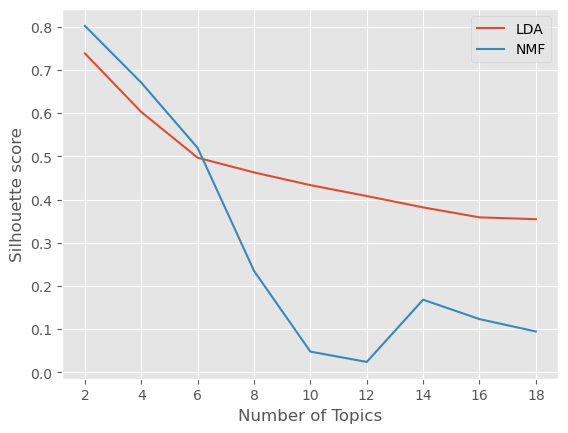

In [111]:
# Plot the accuracy scores for different number of topics
plt.plot(num_topics, lda_scores, label='LDA')
plt.plot(num_topics, nmf_scores, label='NMF')
plt.xlabel('Number of Topics')
plt.ylabel('Silhouette score')
plt.legend()
plt.show()

In [112]:
# Get the number of topics with the highest silhouette score
best_n_topics_nmf = num_topics[np.argmax(nmf_scores)]
best_n_topics_lda = num_topics[np.argmax(lda_scores)]

In [113]:
# Use the best number of topics to fit models
nmf = NMF(n_components=best_n_topics_nmf, max_iter=300)
lda = LatentDirichletAllocation(n_components=best_n_topics_lda, max_iter=300)

In [114]:
# Get the true labels
true_tags = [np.argmax(tags[i]) for i in range(tags.shape[0])]

In [116]:
def evaluate_model(model, vectorized_data, true_tags):
    """
    Given a model, texts, and true tags, 
    calculates the accuracy score and F1 score.
    """
    start_time = time.time()
    
    # Fit the model to the data
    model.fit(vectorized_data)

    # Get the predicted labels for the data
    pred_tags = model.transform(vectorized_data).argmax(axis=1)

    # Calculate the accuracy score
    acc_score = accuracy_score(true_tags, pred_tags)
    print(f'Accuracy score: {acc_score:.3f}')

    # Calculate the F1 Score
    f1_sc = f1_score(true_tags, pred_tags, average='weighted')
    print(f'F1 Score: {f1_sc:.3f}')

    # Calculate the precision
    precision = precision_score(true_tags, pred_tags, average='weighted')
    print(f'Precision: {precision:.3f}')

    # Calculate the recall
    recall = recall_score(true_tags, pred_tags, average='weighted', zero_division=0)   
    print(f'Recall: {recall:.3f}')

    end_time = time.time()
    print("Time taken: ", end_time - start_time)

    # Return the results as a Pandas series
    return pd.Series({"accuracy_score": acc_score, "f1_score": f1_sc, 'precision': precision, 'recall': recall})

In [117]:
scores['LDA'] = evaluate_model(lda, texts, true_tags)

Accuracy score: 0.001
F1 Score: 0.000
Precision: 0.000
Recall: 0.001
Time taken:  218.7689712047577


C:\Users\Simon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [118]:
scores['NMF'] = evaluate_model(nmf, texts, true_tags)

Accuracy score: 0.001
F1 Score: 0.000
Precision: 0.000
Recall: 0.001
Time taken:  0.059046030044555664


C:\Users\Simon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
scores['LDA'] = evaluate_model(lda, texts, true_tags)

Accuracy score: 0.431
F1 Score: 0.602
Precision: 1.000
Recall: 0.431
Time taken:  15.947980642318726


In [85]:
scores['NMF'] = evaluate_model(nmf, texts, true_tags)

Accuracy score: 0.029
F1 Score: 0.057
Precision: 1.000
Recall: 0.029
Time taken:  0.0587923526763916


## <font color="#114b98" id="section_3">3. Approche supervisée avec TF-IDF</font>

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocabulary_tags)

In [33]:
X = tfidf_vectorizer.fit_transform(flat_texts)

In [34]:
tfidf_data = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [35]:
print("Affichage des 15 premiers textes vectorisés par TF-IDF")
tfidf_data.head(15)

Affichage des 15 premiers textes vectorisés par TF-IDF


,code-formatting,vbox,named-pipes,attributeerror,cheerio,vinyl,git-fork,githooks,arabic-support,axapta,...,cdc,google-compute-engine,zend-framework,graceful-degradation,llvm,instantiation,marshalling,android-5.0-lollipop,geotiff,ping
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, flat_tags, test_size=0.2)

In [37]:
# Train a naive bayes classifier on the training data, and make predictions on the test data
start_time = time.time()

clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

end_time = time.time()
print("Time taken: ", end_time - start_time)

NameError: name 'MultinomialNB' is not defined

In [ ]:
# Evaluate the model's accuracy
print(accuracy_score(y_test, y_pred))

## <font color="#114b98" id="section_4">4. Approche supervisée avec bag-of-words</font>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# Convert text data to numerical feature vectors using bag of words
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(flat_texts)

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, flat_tags, test_size=0.2)

In [ ]:
# Train a naive bayes classifier on the training data, and make predictions on the test data
start_time = time.time()

clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

end_time = time.time()
print("Time taken: ", end_time - start_time)

In [ ]:
# Evaluate the model's accuracy
print(accuracy_score(y_test, y_pred))

## <font color="#114b98" id="section_5">5. Approche supervisée avec Word Embedding : Word2Vec</font>

In [ ]:
from gensim.models import Word2Vec
from sklearn.svm import SVC

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [ ]:
texts_t = [word_tokenize(sent) for text in flat_texts for sent in sent_tokenize(text)]

In [ ]:
# Train a Word2Vec model on the text data
model = Word2Vec(texts_t, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Create feature vectors for the text data by averaging the word vectors
X = []
for text in texts_t:
    feature_vec = np.zeros(100)
    n_words = 0
    for word in text:
        if word in model.wv:
            feature_vec = np.add(feature_vec, model.wv[word])
            n_words += 1
    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)
    X.append(feature_vec)

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, flat_tags, test_size=0.2)

In [ ]:
# Train a naive bayes classifier on the training data, and make predictions on the test data
start_time = time.time()

clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

end_time = time.time()
print("Time taken: ", end_time - start_time)

In [ ]:
# Evaluate the model's accuracy
print(accuracy_score(y_test, y_pred))

## <font color="#114b98" id="section_6">6. Approche supervisée avec Word Embedding : BERT</font>

In [ ]:
# !pip install transformers

In [ ]:
# !pip install --user TensorFlow

In [ ]:
# !pip install torch

In [ ]:
# conda install pytorch torchvision torchaudio cpuonly -c pytorch

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertTokenizer
import torch
import torchvision

In [ ]:
# Load the BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
# Encode the text data as input for the BERT model
input_ids = []
attention_masks = []
for text in flat_texts:
    encoded_text = tokenizer.encode_plus(text, add_special_tokens=True, max_length=512, pad_to_max_length=True)
    input_ids.append(encoded_text["input_ids"])
    attention_masks.append(encoded_text["attention_mask"])

In [ ]:
# Convert the lists to PyTorch tensors
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(flat_tags)

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2)

In [ ]:
# Create a DataLoader for the training set
train_dataloader = torch.utils.data.DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=True
)

In [ ]:
# Create an optimizer and scheduler for fine-tuning the BERT model
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 5)

In [ ]:
# Fine-tune the BERT model on the training data
for epoch in range(5):
    model.train()
    for step, batch in enumerate(train_dataloader):
        input_ids, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks)
        loss = criterion(outputs[0], labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [ ]:
# Make predictions on the test data
model.eval()
with torch.no_grad():
    test_logits = model(X_test, attention_mask=attention_masks)

In [ ]:
# Convert the logits to predictions
test_preds = torch.argmax(test_logits, axis=1)

In [ ]:
# Evaluate the model's accuracy on the test data
print(accuracy_score(y_test, test_preds))

## <font color="#114b98" id="section_7">7. Approche supervisée avec Sentence Embedding : USE</font>

In [ ]:
!pip install tensorflow

In [ ]:
!pip install tensorflow_hub

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

In [ ]:
# Load the USE model
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
# Encode the text data as input for the USE model
X = use_model(flat_texts).numpy()

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, flat_tags, test_size=0.2)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Train a classifier on the encoded text data
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(flat_tags)), activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
# Evaluate the model's accuracy on the test data
print(accuracy_score(y_test, y_pred))